In [3]:
import gitlab
import pandas as pd
import pickle
import os
import numpy as np
import gc

In [4]:
issue_file_path = os.path.join("..","data", "gitlab-issues.pkl")

In [5]:
if os.path.isfile(issue_file_path):
    issues = pickle.load( open( issue_file_path, "rb" ))
else:
    raise Exception("Please download the data with the Gitlab-issues notebook")

In [6]:
def _get_issues(issues, project):
    '''
    Create Pandas df from the issue data
    '''
    df_issues = pd.DataFrame(columns=['id',
                                      'desc',
                                      'title',
                                      'tags',
                                      'project',
                                      'created_at'])
    for issue in issues:
        df_issues = df_issues.append({'id': issue.id,
                       'desc' : issue.attributes['description'],
                       'title' : issue.attributes['title'],
                       'tags' : issue.attributes['labels'],
                       'project' : project,
                       'created_at' : issue.attributes['created_at']}, ignore_index=True)
    return df_issues

df_issues = pd.concat([_get_issues(issues[0], 'GitLab Community Edition'),
                          _get_issues(issues[1], 'GitLab Enterprise Edition')],
                      ignore_index=True)
df_issues.head()

id                                               desc  \
0  13308948  ### Summary\n\nIf repository mirroring fails (...   
1  13308533  ### Problem to solve\nIt would be nice to be a...   
2  13307635  Hi, I'm doing setup gitlab-ce with docker.\n\n...   
3  13307532  After I backup and restore the gitlab to anoth...   
4  13307385  <!---\nPlease read this!\n\nBefore opening a n...   

                                               title tags  \
0  Text and Background color hides error message ...   []   
1                                      Timed Tickets   []   
2  Set my domain to Project path at new creation ...   []   
3  Registry doesn't work properly after backup an...   []   
4  Filename has been changed if upload via web in...   []   

                    project                created_at  
0  GitLab Community Edition  2018-08-08T06:56:56.268Z  
1  GitLab Community Edition  2018-08-08T06:25:43.101Z  
2  GitLab Community Edition  2018-08-08T04:40:04.743Z  
3  GitLab Community Edition  2018-08-08T04:25:18.021Z  
4  GitLab Community Edition  2018-08-08T04:07:15.305Z

In [7]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup
from markdown import markdown
import re

from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

nlp = spacy.load('en_core_web_sm')
word_split = re.compile('[^a-zA-Z0-9_\\+\\-/]')

# After checking the first result these should be removed as well
CUSTOM_WORDS = {'ok', 'head', 'ago', 'author1', 'n', 'days', 'yes', 'no', 'hours', 'description', 'summary'}

def cleanText(x):
    html = markdown(x)
    text = ''.join(BeautifulSoup(html).findAll(text=True))
    filtered_words = [word.strip().lower() for word in word_split.split(text) if word not in STOP_WORDS.union(CUSTOM_WORDS)]
    return re.sub(' +',' '," ".join(filtered_words))

C:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [8]:
df_issues['issue_text'] = (df_issues['title'].astype(str) + ' ' + df_issues['desc']).map(cleanText)

C:\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [10]:
df_issues.to_pickle(os.path.join("..","data", "train.pkl"))

This is inelegant but takes a lot of time to pre-process the data so I'm caching it.

In [11]:
df_issues = pd.read_pickle(os.path.join("..","data", "train.pkl"))

In [3]:
import copy
def pandas_explode(df, column_to_explode):
    """
    Similar to Hive's EXPLODE function, take a column with iterable elements, and flatten the iterable to one element 
    per observation in the output table

    :param df: A dataframe to explod
    :type df: pandas.DataFrame
    :param column_to_explode: 
    :type column_to_explode: str
    :return: An exploded data frame
    :rtype: pandas.DataFrame
    """

    # Create a list of new observations
    new_observations = list()

    # Iterate through existing observations
    for row in df.to_dict(orient='records'):

        # Take out the exploding iterable
        explode_values = row[column_to_explode]
        del row[column_to_explode]

        # Create a new observation for every entry in the exploding iterable & add all of the other columns
        for explode_value in explode_values:

            # Deep copy existing observation
            new_observation = copy.deepcopy(row)

            # Add one (newly flattened) value from exploding iterable
            new_observation[column_to_explode] = explode_value

            # Add to the list of new observations
            new_observations.append(new_observation)

    # Create a DataFrame
    return_df = pd.DataFrame(new_observations)

    # Return
    return return_df

In [4]:
df_train = pandas_explode(df_issues, 'tags')
del(df_issues);
gc.collect();

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7]

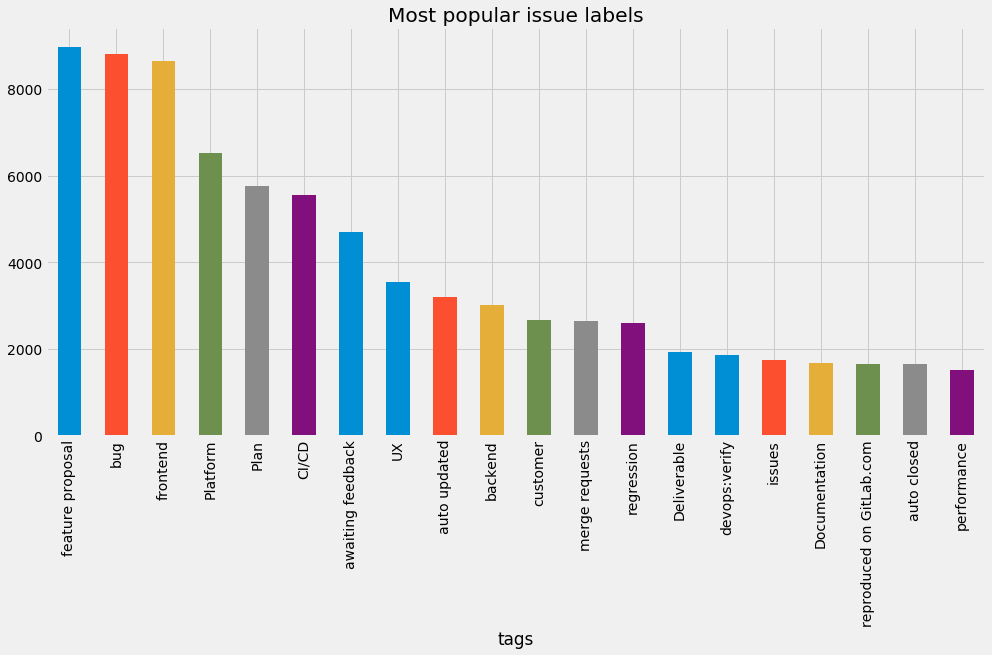

In [37]:
df_train.groupby('tags')\
    .size()\
    .sort_values(ascending = False)\
    .head(20)\
    .plot(kind = 'bar');
plt.title('Most popular issue labels');

Later I might have to exclude some of the labels. Awaiting feedback should come from comments or I'm not sure the model will handle reproduced on Gitlab.com. Let's keep those and see the first results.

In [12]:
df_train.head(10)

created_at  \
0  2018-08-07T23:33:02.341Z   
1  2018-08-07T23:33:02.341Z   
2  2018-08-07T23:33:02.341Z   
3  2018-08-07T23:33:02.341Z   
4  2018-08-07T23:33:02.341Z   
5  2018-08-07T23:33:02.341Z   
6  2018-08-07T23:06:49.582Z   
7  2018-08-07T23:06:49.582Z   
8  2018-08-07T22:00:52.545Z   
9  2018-08-07T22:00:52.545Z   

                                                desc  \
0  ### Problem to solve\n\nAs well-articulated in...   
1  ### Problem to solve\n\nAs well-articulated in...   
2  ### Problem to solve\n\nAs well-articulated in...   
3  ### Problem to solve\n\nAs well-articulated in...   
4  ### Problem to solve\n\nAs well-articulated in...   
5  ### Problem to solve\n\nAs well-articulated in...   
6  ### Problem to solve\n\nOne of the low-hanging...   
7  ### Problem to solve\n\nOne of the low-hanging...   
8  ### Summary\n\nAdding issues to a list where t...   
9  ### Summary\n\nAdding issues to a list where t...   

                                              desc_c        id  \
0  problem solve as well-articulated https //gitl...  13305570   
1  problem solve as well-articulated https //gitl...  13305570   
2  problem solve as well-articulated https //gitl...  13305570   
3  problem solve as well-articulated https //gitl...  13305570   
4  problem solve as well-articulated https //gitl...  13305570   
5  problem solve as well-articulated https //gitl...  13305570   
6  problem solve one low-hanging fruit speeding c...  13305411   
7  problem solve one low-hanging fruit speeding c...  13305411   
8  summary adding issues list board scoped any no...  13304921   
9  summary adding issues list board scoped any no...  13304921   

                    project              tags  \
0  GitLab Community Edition            Manage   
1  GitLab Community Edition           backend   
2  GitLab Community Edition     devops:manage   
3  GitLab Community Edition  feature proposal   
4  GitLab Community Edition        gitlab.com   
5  GitLab Community Edition          security   
6  GitLab Community Edition             CI/CD   
7  GitLab Community Edition     devops:verify   
8  GitLab Community Edition              Plan   
9  GitLab Community Edition            boards   

                                               title  
0  Warn users when their account uses a potential...  
1  Warn users when their account uses a potential...  
2  Warn users when their account uses a potential...  
3  Warn users when their account uses a potential...  
4  Warn users when their account uses a potential...  
5  Warn users when their account uses a potential...  
6  Document information and tips on improving spe...  
7  Document information and tips on improving spe...  
8  Adding issues to a list where the board is sco...  
9  Adding issues to a list where the board is sco...

In [5]:
from comet_ml import Experiment

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

import nltk
from nltk.tokenize import ToktokTokenizer

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if 'COMET_ML_TOKEN' in os.environ:
    COMET_ML_TOKEN = os.environ['COMET_ML_TOKEN']
    experiment = Experiment(api_key=COMET_ML_TOKEN,
                            project_name="gitlab-issue-label-cf",
                            workspace="metricbrew",
                            log_git_metadata=True)
else:
    raise Exception("Please set your Comet ml token. https://www.comet.ml")

NameError: name 'os' is not defined

## Comet url to check performance

https://www.comet.ml/metricbrew/gitlab-issue-label-classification

In [1]:
# After quickly going through on the labels these seems unpredictable

drop_labels = ['In review', 'auto updated', 'auto closed','missed-deliverable', 'awaiting feedback',
               'Accepting Merge Requests', 'In dev', 'Next Patch Release', 'regression:10.x',
               'blocked', 'regression:11.2', 'due-22nd', 'Pick into 10.6',  'Pick into 10.8',
               'Pick into 11.1',  'Pick into 10.7', 'promised' ]

# First results showed I tried to predict too much labels. Try to use another approach with specify some labels at the beginning
# It's based on the top tags:
#df_train.groupby('tags')\
#    .size()\
#    .sort_values(ascending = False)\
#    .head(100).reset_index()['tags'].values

# After some iteration I feel I have to invest more time to understend how the issue labes are working 

use_labels = ['feature proposal', 'bug', 'frontend','Create', 'Platform', 'Plan', 'CI/CD','UX',  'backend', 'customer',
              'regression', 'api', 'performance' ,'Geo', 'database', 'UI polish', 'devops:create', 'Manage'
              'import', 'Monitoring','potential proposal', 'security','customer+', 'authentication','boards',
              'admin dashboard',  'Security Products','container registry', 'webhooks', 'devops:release',
              'Gitaly','ci-build', 'kubernetes',  'installation']

experiment.log_parameter('dropped_labels',drop_labels)
experiment.log_parameter('use_labels',use_labels)

df_train = df_train[(~df_train.tags.isin(drop_labels)) & (df_train.tags.isin(use_labels))]

x= nltk.FreqDist(ToktokTokenizer().tokenize(" ".join(df_train['desc_c'].values)))

desc_train, desc_test, tags_train, tags_test = train_test_split(df_train['desc_c'], df_train['tags'], test_size = 0.15, random_state = 123)

NameError: name 'experiment' is not defined

In [10]:
print('Gitlab issues has over {} unique words '.format(len(x)))

Gitlab issues has over 218789 unique words 


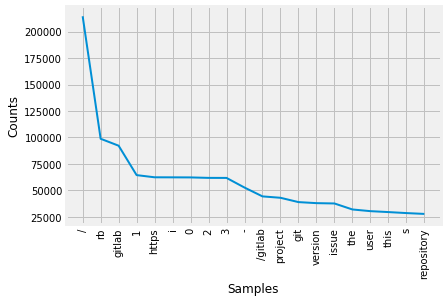

In [11]:
x.plot(20)

In [9]:
del(df_train);

In [10]:
# As a first trial let's use 40% of the vocab
# Due to memory error let's use 20% of the vocab
# Dropping out some labels resulted in I can use 30% of the vocab
max_words = int(np.round(len(x) * 0.30))
experiment.log_parameter('max_words',max_words)
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [11]:
del(x);
gc.collect();

In [12]:
# Encoding 
encoder = LabelBinarizer()
encoder.fit(tags_train)
# Make sure we use only labels from the train dataset
filter_tags = np.in1d(tags_test, tags_train.unique())

Y_train = encoder.transform(tags_train)
Y_test = encoder.transform(tags_test[filter_tags])

num_classes = len(tags_train.unique())


In [13]:
#Build internal vocabulary
tokenize.fit_on_texts(desc_train)
X_train = tokenize.texts_to_matrix(desc_train)
X_test = tokenize.texts_to_matrix(desc_test[filter_tags])

In [15]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

experiment.log_dataset_hash(X_train)

X_train shape: (58246, 65637)
X_test shape: (10279, 65637)
Y_train shape: (58246, 32)
Y_test shape: (10279, 32)


In [16]:
batch_size = 32
epochs = 5
loss_function = 'categorical_crossentropy'
optimizer = 'adam'
metric = ['accuracy', 'top_k_categorical_accuracy']
dropout_rate = 0.5
validation_split=0.2

params={
    "batch_size": batch_size,
    "epochs": epochs,
    "num_classes": num_classes,
    "optimizer": optimizer,
    "loss_func" : loss_function,
    "metric" : metric,
    "dropout": dropout_rate,
    "validation_split" : validation_split}

experiment.log_multiple_params(params)

# Build the model
model = Sequential()
model.add(Dense(768, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=metric)
with experiment.train():
    history = model.fit(X_train, 
                        Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=validation_split)

Train on 46596 samples, validate on 11650 samples
Epoch 1/5
46596/46596 [==============================] - 203s 4ms/step - loss: 2.2852 - acc: 0.2891 - top_k_categorical_accuracy: 0.7820 - val_loss: 2.1089 - val_acc: 0.2932 - val_top_k_categorical_accuracy: 0.8288
Epoch 2/5
46596/46596 [==============================] - 222s 5ms/step - loss: 1.8935 - acc: 0.3455 - top_k_categorical_accuracy: 0.8810 - val_loss: 2.1822 - val_acc: 0.2492 - val_top_k_categorical_accuracy: 0.8384
Epoch 3/5
46596/46596 [==============================] - 203s 4ms/step - loss: 1.7094 - acc: 0.3790 - top_k_categorical_accuracy: 0.9215 - val_loss: 2.3180 - val_acc: 0.2139 - val_top_k_categorical_accuracy: 0.8355
Epoch 4/5
46596/46596 [==============================] - 210s 4ms/step - loss: 1.5941 - acc: 0.4071 - top_k_categorical_accuracy: 0.9447 - val_loss: 2.4632 - val_acc: 0.1964 - val_top_k_categorical_accuracy: 0.8398
Epoch 5/5
46596/46596 [==============================] - 192s 4ms/step - loss: 1.5156 - ac

In [17]:
# Evaluate the accuracy of our trained model
with experiment.test():
    loss, accuracy, top_k_categorical_accuracy = model.evaluate(X_test, 
                           Y_test,
                           verbose=1)
    print(loss, accuracy, top_k_categorical_accuracy)
    metrics = {
      'loss':loss,
      'accuracy':accuracy,
      'top_k_categorical_accuracy' : top_k_categorical_accuracy  
    }
    experiment.log_multiple_metrics(metrics)

10279/10279 [==============================] - 14s 1ms/step
2.5218192894109226 0.1783247397650261 0.8340305477244484


In [18]:
experiment.log_other("comments", "")

# Todo list

- [x] Use only labels that common
- [x] Use a more complex model so for instance add LSTM. comment: Currently seems more complex models can't increase accuracy
- [] Understand better how labels are applied
- [] What about use all the labels for validation not just the first predicted one?
- [x] Check the confusion matrix
- [x] Make sure issue templates don't cause model leakage
- [x] Move it to ~~Colab or~~ GCP as I reached the limits of this machine 
- [x] Include the issues' title to the model as well

In [21]:
# Check the results
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[prediction.flatten().argsort()[-3:][::-1]]
    print(desc_test.iloc[i][:200], "...")
    print('Actual label:' + tags_test.iloc[i])
    print("Predicted label: " + np.array2string(predicted_label) + "\n")

i 500 error query https //dev gitlab org/search group_id scope merge_requests search test ...
Actual label:regression
Predicted label: ['bug' 'Plan' 'regression']

i m trying add marin project member i know exact gitlab username i type member add form user doesn t come options  ...
Actual label:bug
Predicted label: ['Platform' 'feature proposal' 'UX']

description we capability deploy helm prometheus ingresses kubernetes unfortunately way update event configuration changes need bump version we need design method proposal target applications installe ...
Actual label:feature proposal
Predicted label: ['backend' 'feature proposal' 'CI/CD']

description time tracking data importantly estimates provide important information planification issue board planification tools provide gitlab benefit displaying time tracking information issue board ...
Actual label:potential proposal
Predicted label: ['Plan' 'boards' 'feature proposal']

summary if repository contains directory blob opened web ide 

In [31]:
import itertools
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [26]:
y_softmax  = model.predict(X_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(Y_test)):
    probs = Y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

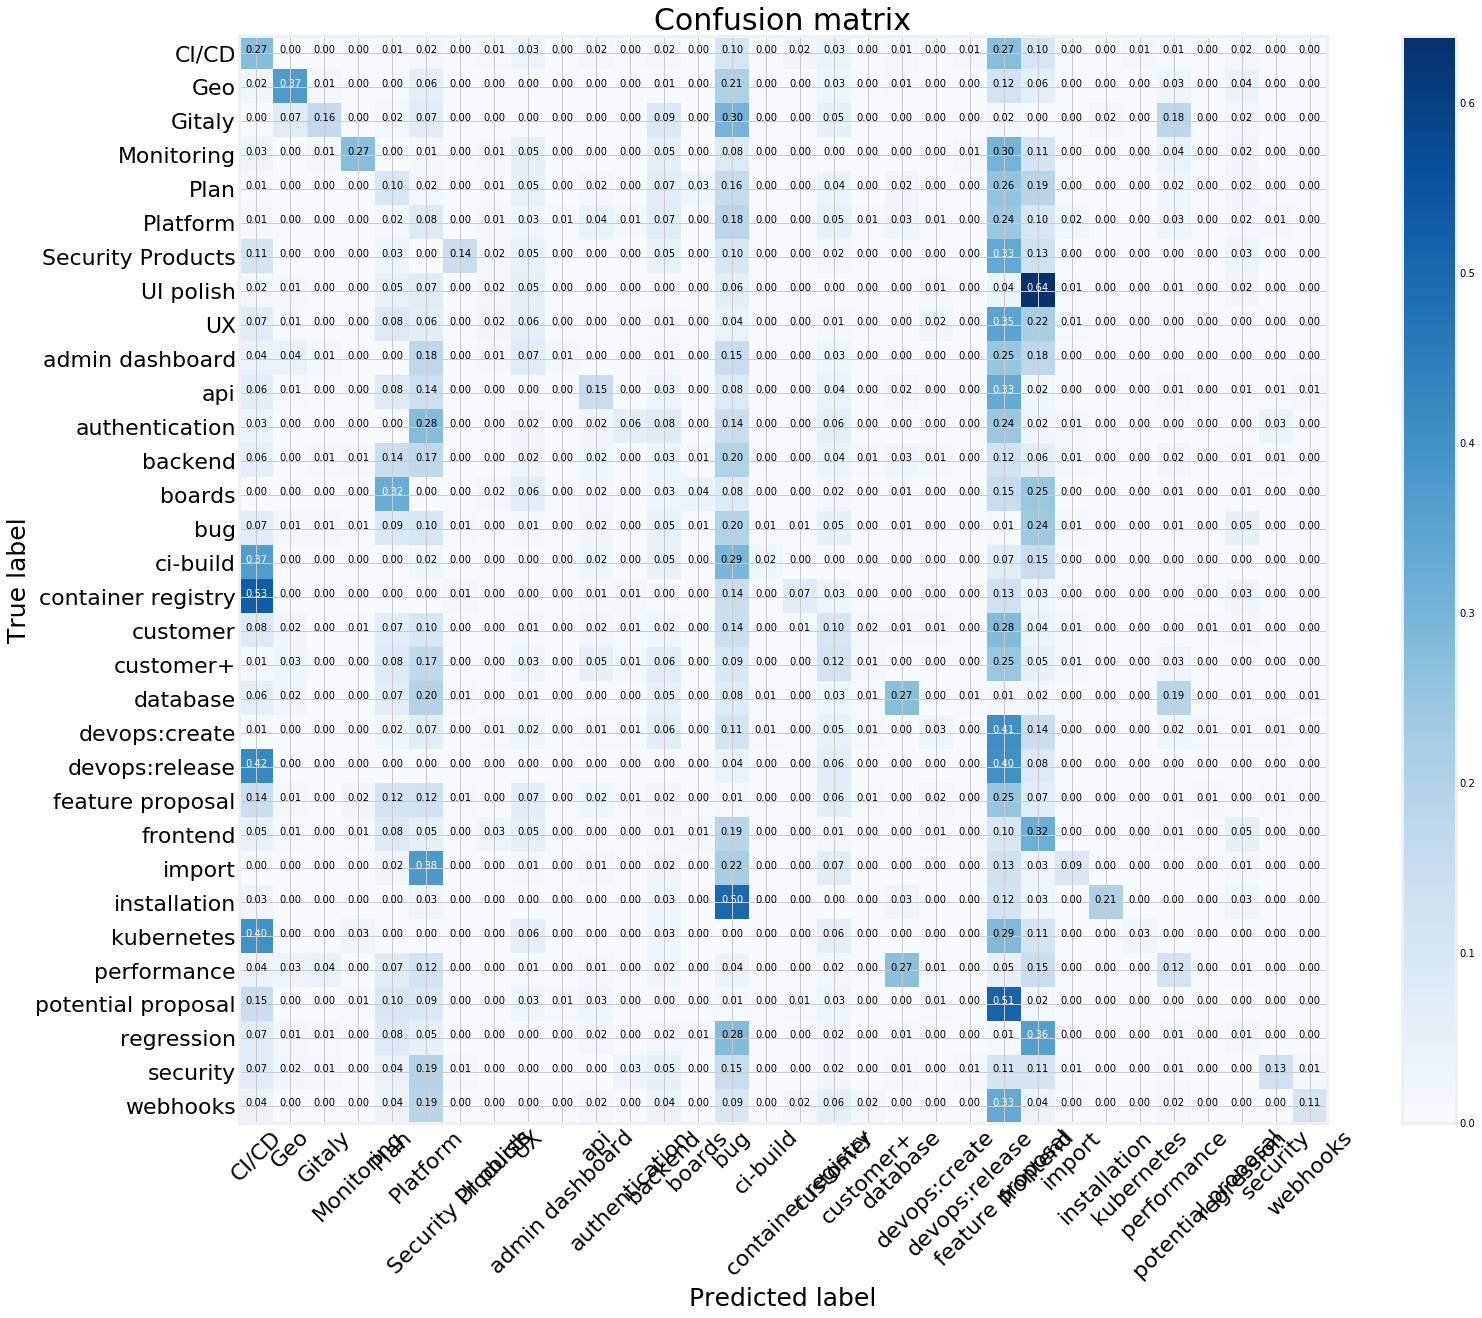

In [32]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

Seems this is useless. I have to take into account first 3-5 predicted labels and not just the first one